In [265]:
import cv2
import sys, os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio

### Test

In [254]:
imageFile = '/Users/markus/Work/data/imdb_crop/00/nm0000100_rm1001569280_1955-1-6_2011.jpg'
cascFile ="/Users/markus/Work/Insight-AI-Project/preprocess/FaceDetect/haarcascade_frontalface_default.xml"
#cascFile ="/Users/markus/Work/Insight-AI-Project/preprocess/haarcascade_frontalface_default.xml"
#cascFile ="/Users/markus/Work/Insight-AI-Project/preprocess/haarcascade_frontalface_eye.xml"

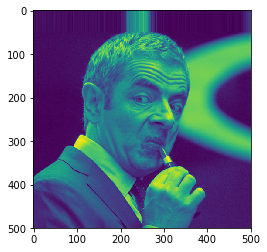

In [255]:
# test
faceCascade = cv2.CascadeClassifier(cascFile)
image = cv2.imread(imageFile)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

### Functions

In [246]:
# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cascFile)


def detectFaces(imageFile,faceCascade):
    # Read the image
    image = cv2.imread(imageFile)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
        # flags = cv2.cv.CV_HAAR_SCALE_IMAGE
        
    )
    #faces = faceCascade.detectMultiScale(gray, 1.3, 5)
    return faces

In [247]:
faces = detectFaces(imageFile,faceCascade)
print("Found {0} faces!".format(len(faces)))

error: /Users/travis/build/skvark/opencv-python/opencv/modules/objdetect/src/cascadedetect.cpp:1681: error: (-215) !empty() in function detectMultiScale


### Check list of images

In [217]:
imagePath = "/Users/markus/Work/data/imdb_crop/00/"
imageList=sorted(os.listdir(imagePath))
nima = len(imageList)
print("Found {} images".format(nima))

ct = time.time()
numFaces=np.zeros(nima)

for k in xrange(nima):
    faces = detectFaces(imagePath+imageList[k],faceCascade)
    numFaces[k] = len(faces)

print("Time = {}".format(time.time()-ct))
print(sum(numFaces==1))

Found 3862 images
Time = 83.2201650143
2175


In [216]:
sum(numFaces==1)

2523

(array([ 1654.,     0.,     0.,     0.,     0.,  2175.,     0.,     0.,
            0.,    33.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

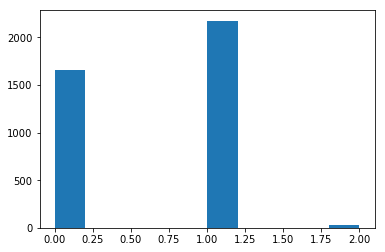

In [218]:
plt.hist(numFaces)

In [219]:
numFaces[:9]

array([ 0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.])

In [228]:
faces = detectFaces(imagePath+imageList[1],faceCascade)

In [229]:
len(faces)

1

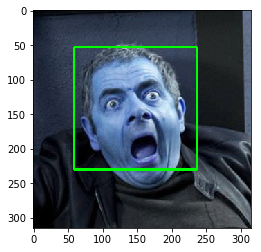

In [235]:
k=2
faces = detectFaces(imagePath+imageList[k],faceCascade)
image = cv2.imread(imagePath+imageList[k],)
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

_=plt.imshow(image)    

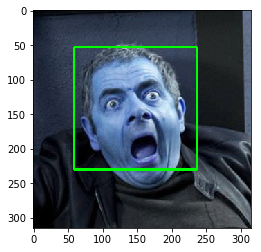

In [233]:
plt.imshow(image)

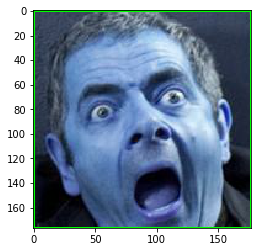

In [238]:
x,y,w,h = faces[0]
cropped = image[y:y+h,x:x+w]

plt.imshow(cropped)

In [174]:
cropped.shape

(60, 60, 3)

In [237]:
x,y,w,h = faces[0]
print x,y,w,h

59 53 177 177


In [206]:
imageList[:9]

['nm0000100_rm1001569280_1955-1-6_2011.jpg',
 'nm0000100_rm1002674432_1955-1-6_2003.jpg',
 'nm0000100_rm1018346496_1955-1-6_2011.jpg',
 'nm0000100_rm1019451648_1955-1-6_2003.jpg',
 'nm0000100_rm103389184_1955-1-6_2005.jpg',
 'nm0000100_rm1035123712_1955-1-6_2011.jpg',
 'nm0000100_rm1036228864_1955-1-6_2003.jpg',
 'nm0000100_rm1051900928_1955-1-6_2011.jpg',
 'nm0000100_rm1069783296_1955-1-6_2003.jpg']

In [239]:
help(cv2.resize)

Help on built-in function resize:

resize(...)
    resize(src, dsize[, dst[, fx[, fy[, interpolation]]]]) -> dst



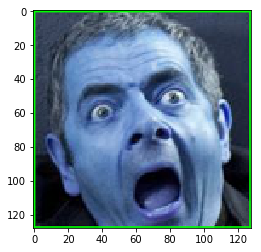

In [243]:
plt.imshow(cv2.resize(cropped,(128,128), interpolation = cv2.INTER_CUBIC))

### Load meta data file including age

In [321]:
metaFile="/Users/markus/Work/data/wiki/wiki_meta.csv"
meta = pd.read_csv(metaFile)

print(meta.shape)
print(sum(meta.face_score<0))
meta.head(3)

(62328, 8)
18016


,full_path,dob,face_location,face_score,gender,photo_taken,second_face_score,age
0,17/10000217_1981-05-05_2009.jpg,723671,111.291 111.291 252.67 252.67,4.3010,1.0,2009,NaN,28
1,48/10000548_1925-04-04_1964.jpg,703186,252.483 126.682 354.532 228.73,2.6456,1.0,1964,1.9492,39
2,12/100012_1948-07-03_2008.jpg,711677,113.52 169.84 366.08 422.4,4.3293,1.0,2008,NaN,59


In [322]:
# clean table
idx = meta.face_score<0
print("Low face score: {}".format(sum(idx)))
meta=meta[~idx]

idx = ~meta.second_face_score.isnull()
print("Two faces: {}".format(sum(idx)))
meta=meta[~idx]

idx = meta.age<0
print("Low age: {}".format(sum(idx)))
meta=meta[~idx]

idx = meta.age>120
print("High age: {}".format(sum(idx)))
meta=meta[~idx]

print(meta.shape)

Low face score: 18016
Two faces: 4096
Low age: 6
High age: 18
(40192, 8)


In [323]:
meta.sort_values(by='full_path',inplace=True)
meta.reset_index(drop=True,inplace=True)
meta.head(10)

,full_path,dob,face_location,face_score,gender,photo_taken,second_face_score,age
0,00/10049200_1891-09-16_1958.jpg,690933,126.869 111.111 267.897 252.138,5.2548,0.0,1958,NaN,66
1,00/10110600_1985-09-17_2012.jpg,725267,217.681 129.039 305.324 216.681,3.6931,1.0,2012,NaN,26
2,00/1013900_1917-10-15_1960.jpg,700458,80.871 90.9204 170.839 180.889,4.1361,1.0,1960,NaN,42
3,00/10166400_1960-03-12_2008.jpg,715947,40.7043 120.353 398.243 477.891,3.8709,1.0,2008,NaN,48
4,00/1024100_1982-06-07_2011.jpg,724069,315.84 62.4 384 130.56,3.2003,1.0,2011,NaN,29
5,00/10292500_1984-03-26_2009.jpg,724727,269.565 44.2163 346.69 121.342,3.2169,1.0,2009,NaN,25
6,00/1035700_1945-11-27_2013.jpg,710728,196.998 74.4241 306.434 183.86,3.3795,1.0,2013,NaN,67
7,00/10525500_1916-02-14_1951.jpg,699849,79.7026 132.251 315.291 367.839,3.8765,1.0,1951,NaN,35
8,00/10623500_1931-09-25_1956.jpg,705551,118.427 74.3167 249.957 205.847,3.9789,0.0,1956,NaN,24
9,00/10870400_1971-06-28_2013.jpg,720072,169.84 183.92 295.68 309.76,2.9951,1.0,2013,NaN,42


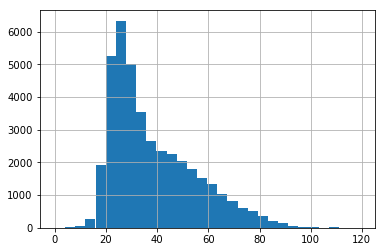

In [327]:
#meta.face_score[meta.face_score>0].hist()
meta.age.hist(bins=30)